## 데이터셋 다운로드

In [70]:
!git clone https://github.com/smartboy110/denoising-datasets.git

fatal: destination path 'denoising-datasets' already exists and is not an empty directory.


In [4]:
!pip install torchinfo

**DnCNN-S** : 알려진 특정 노이즈 레벨(15,25,50)을 가진 가우시안 노이즈 제거를 위한 모델 <br> patch_size=40 <br>
**DnCNN-B**: 블라인드 가우시안 노이즈(0~55) 제거를 위한 모델 <br> patch_size=50 <br>
**CDnCNNB** : 블라인드 컬러 노이즈 제거 모델 <br> patch_size=50<br>

In [5]:
import os
import copy
import time
import torch
import random
import numpy as np
from PIL import Image
from torchinfo import summary

import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import functional as F

In [71]:
class Config:
  #Path
  train_data_root = "denoising-datasets/BSD400"
  test_data_root = "denoising-datasets/BSD68"

  # Dataset
  patch_size = 50
  train_ratio=0.9
  patches_per_image = 200
  # DnCNN-B 노이즈
  sigma_range=(0,55)

  #Model
  num_layers=20
  in_channels=1
  out_channels=64
  kernel_size=3

  #Training
  batch_size=128
  num_epochs=50
  learning_rate=1e-3

config = Config()

## Data Loading & Preprocessing

In [72]:
class DnCNN_Dataset(Dataset):
  def __init__(self, root, file_list, patch_size, sigma_range, patches_per_image=1000, is_train=True):
    self.root = root
    self.file_list = file_list
    self.patch_size = patch_size
    self.is_train = is_train
    # sigma
    self.sigma_min = sigma_range[0] / 255.0  # 0 / 255 = 0
    self.sigma_max = sigma_range[1] / 255.0  # 55 / 255 = 0.216
    self.patches_per_image = patches_per_image if is_train else 1

    if not is_train:
            self.fixed_data = []
            for idx in range(len(file_list)):
                img = Image.open(os.path.join(root, file_list[idx])).convert('L')
                img = np.array(img, dtype=np.float32) / 255.0
                h, w = img.shape[:2]
                top = random.randint(0, h - patch_size)
                left = random.randint(0, w - patch_size)
                patch = img[top:top+patch_size, left:left+patch_size]
                clean = torch.from_numpy(patch).unsqueeze(0)
                sigma = random.uniform(self.sigma_min, self.sigma_max)
                noise = torch.randn_like(clean) * sigma
                noisy = clean + noise
                self.fixed_data.append((noisy, clean))

  def __len__(self):
    return len(self.file_list)*self.patches_per_image

  def __getitem__(self, index):
    if not self.is_train:
            return self.fixed_data[index]
    img_idx = index % len(self.file_list)
    img = Image.open(os.path.join(self.root, self.file_list[img_idx])).convert('L')
    img = np.array(img, dtype=np.float32)/255.0

    h,w = img.shape[:2]
    top = random.randint(0, h-self.patch_size)
    left = random.randint(0, w-self.patch_size)

    patch = img[top:top+self.patch_size, left:left+self.patch_size]
    #Random Rotation + randomfilp 적용
    k = random.randint(0,3)
    patch = np.rot90(patch, k).copy()
    if random.random() >0.5:
        patch = np.fliplr(patch).copy() 
      
    # Tensor 변환
    clean = torch.from_numpy(patch).unsqueeze(0)

    # Gaussian noise 추가
    sigma = random.uniform(self.sigma_min, self.sigma_max)  # 0 ~ 0.216
    noise = torch.randn_like(clean) * sigma
    noisy = clean + noise
    '''
      # RGB 이미지일 경우
      img = Image.open(os.path.join(self.root, self.files[idx])).convert('RGB')
      img = np.array(img, dtype=np.float32) / 255.0

      h, w, c = img.shape
      i = np.random.randint(0, h - self.patch_size + 1)
      j = np.random.randint(0, w - self.patch_size + 1)

      patch = img[i:i+self.patch_size, j:j+self.patch_size, :]

      # [H, W, C] -> [C, H, W]
      clean = torch.from_numpy(patch).permute(2, 0, 1)

      sigma = random.uniform(self.sigma_min, self.sigma_max)  # 0 ~ 0.216
      noise = torch.randn_like(clean) * sigma
      noisy = clean + noise
      '''

    return noisy, clean

In [73]:
# 이미지 파일만 필터링
def get_image_files(directory):
    """
    디렉토리에서 이미지 파일만 필터링
    """
    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}
    all_files = os.listdir(directory)
    image_files = [f for f in all_files
                   if os.path.splitext(f)[1].lower() in valid_extensions]
    return sorted(image_files)

train_files = get_image_files(config.train_data_root)
#test_files = get_image_files(config.test_data_root)
total = len(train_files)

train_end = int(config.train_ratio * total)

train_list = train_files[:train_end]
val_list = train_files[train_end:]
#test_list = test_files[::]

print(f'Total: {total}')
print(f'Train: {len(train_list)}')
print(f'Val:   {len(val_list)}')
#print(f'Test:  {len(test_list)}')

Total: 400
Train: 360
Val:   40



Sample Visualization: Noisy vs Clean
Sample 1:
  Clean range: [0.220, 0.906]
  Noisy range: [0.143, 0.960]
  Noise std: 0.0307 (7.82/255)
Sample 2:
  Clean range: [0.122, 0.702]
  Noisy range: [-0.080, 0.900]
  Noise std: 0.0993 (25.33/255)
Sample 3:
  Clean range: [0.078, 0.992]
  Noisy range: [0.074, 1.002]
  Noise std: 0.0032 (0.82/255)
Sample 4:
  Clean range: [0.290, 0.996]
  Noisy range: [-0.097, 1.264]
  Noise std: 0.1686 (42.98/255)
Sample 5:
  Clean range: [0.173, 0.616]
  Noisy range: [-0.217, 0.879]
  Noise std: 0.1543 (39.34/255)


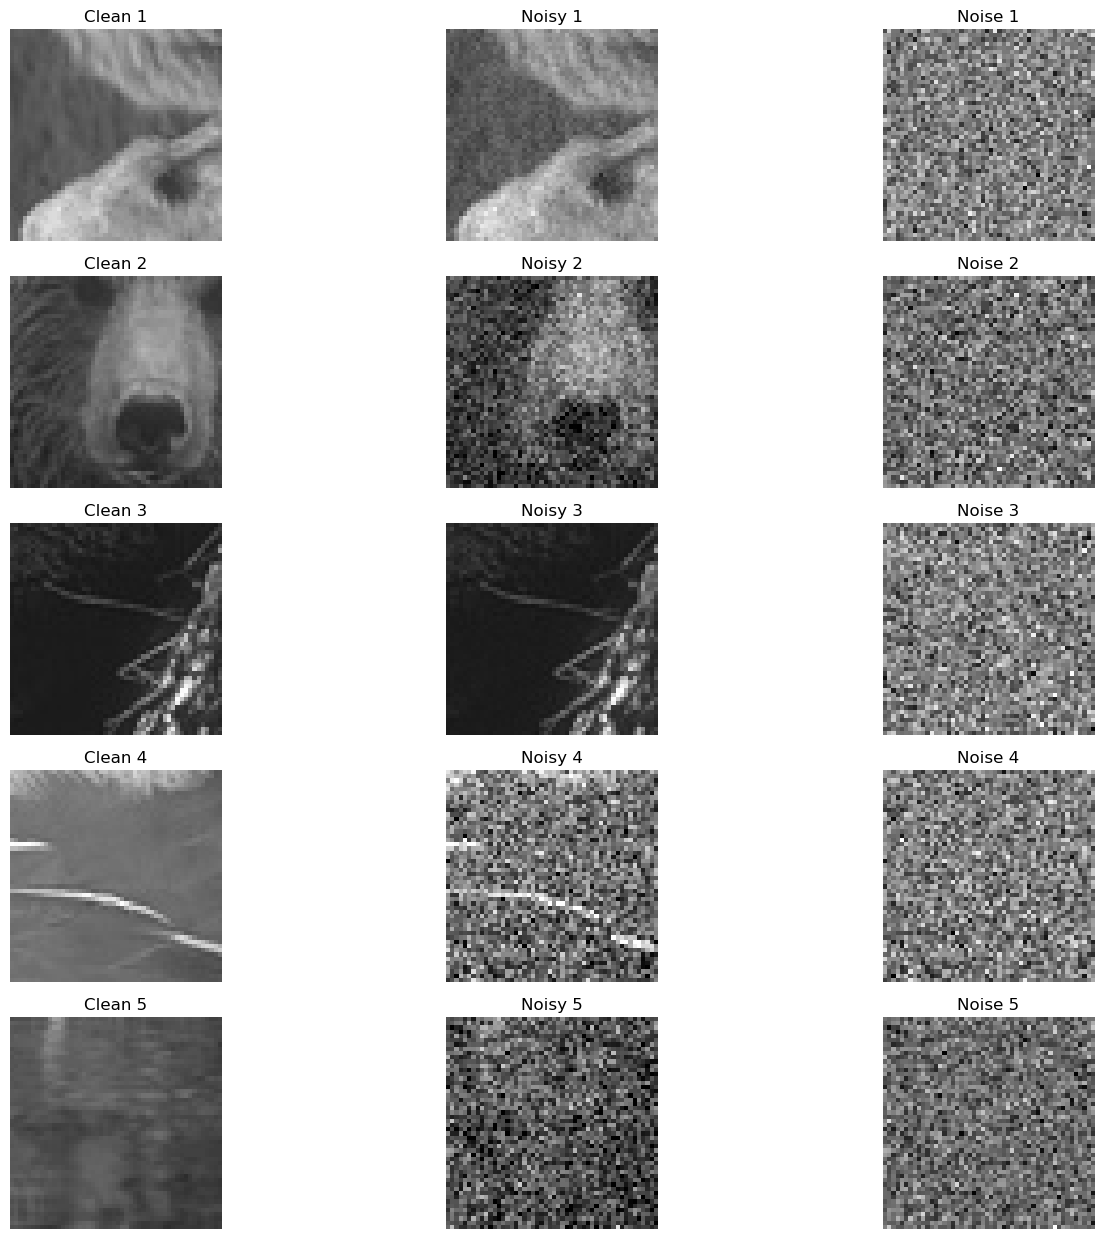

In [74]:
train_dataset_vis = DnCNN_Dataset(
    root=config.train_data_root,
    file_list=train_list,
    patch_size=config.patch_size,
    sigma_range=config.sigma_range,
    patches_per_image=config.patches_per_image,
    is_train=True
)

def visualize_samples_debug(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*2.5))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        noisy, clean = dataset[i]

        # [1, H, W] -> [H, W]
        noisy_np = noisy.squeeze().numpy()
        clean_np = clean.squeeze().numpy()
        noise_np = (noisy - clean).squeeze().numpy()

        # 통계 정보
        print(f'Sample {i+1}:')
        print(f'  Clean range: [{clean_np.min():.3f}, {clean_np.max():.3f}]')
        print(f'  Noisy range: [{noisy_np.min():.3f}, {noisy_np.max():.3f}]')
        print(f'  Noise std: {noise_np.std():.4f} ({noise_np.std()*255:.2f}/255)')

        # Clip to [0, 1] for visualization
        noisy_display = np.clip(noisy_np, 0, 1)
        clean_display = np.clip(clean_np, 0, 1)

        # Clean 이미지
        axes[i, 0].imshow(clean_display, cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Clean {i+1}')
        axes[i, 0].axis('off')

        # Noisy 이미지
        axes[i, 1].imshow(noisy_display, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f'Noisy {i+1}')
        axes[i, 1].axis('off')

        # Noise만 (시각화용)
        noise_display = noise_np - noise_np.min()
        noise_display = noise_display / (noise_display.max() + 1e-8)
        axes[i, 2].imshow(noise_display, cmap='gray')
        axes[i, 2].set_title(f'Noise {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# 샘플 시각화
print('\n' + '='*70)
print('Sample Visualization: Noisy vs Clean')
print('='*70)
visualize_samples_debug(train_dataset_vis, num_samples=5)


In [59]:
def check_noise_levels(dataset, num_samples=10):
    """
    여러 샘플의 노이즈 레벨과 PSNR 확인
    """
    print('\n' + '='*70)
    print('Noise Level Check')

    for i in range(num_samples):
        noisy, clean = dataset[i]

        # MSE 계산
        mse = torch.mean((noisy - clean) ** 2).item()
        psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')

        # 노이즈 강도 (std)
        noise = noisy - clean
        noise_std = torch.std(noise).item() * 255  # [0, 255] 스케일로 변환

        print(f'Sample {i+1}: Noise σ ≈ {noise_std:.2f}, PSNR: {psnr:.2f} dB')

check_noise_levels(train_dataset_vis, num_samples=10)


Noise Level Check
Sample 1: Noise σ ≈ 24.24, PSNR: 20.44 dB
Sample 2: Noise σ ≈ 4.60, PSNR: 34.88 dB
Sample 3: Noise σ ≈ 2.33, PSNR: 40.80 dB
Sample 4: Noise σ ≈ 33.86, PSNR: 17.54 dB
Sample 5: Noise σ ≈ 13.95, PSNR: 25.24 dB
Sample 6: Noise σ ≈ 15.36, PSNR: 24.40 dB
Sample 7: Noise σ ≈ 9.19, PSNR: 28.86 dB
Sample 8: Noise σ ≈ 33.98, PSNR: 17.51 dB
Sample 9: Noise σ ≈ 16.88, PSNR: 23.58 dB
Sample 10: Noise σ ≈ 41.08, PSNR: 15.86 dB


## Model Architecture

In [60]:
class DnCNN(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size):
    super(DnCNN, self).__init__()

    layers =[]
    padding = kernel_size // 2

    # First Layer
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
    layers.append(nn.ReLU(inplace=True))

    # Mid Layer
    for _ in range(depth-2):
      layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))

    # Last Layer
    layers.append(nn.Conv2d(out_channels, 1, kernel_size=kernel_size, padding=padding))

    self.dncnn = nn.Sequential(*layers)
    self._initialize_weights()

  # Weight Initialization
  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

  # Residual Learning 노이즈만 출력
  def forward(self, x):
    return self.dncnn(x)


In [61]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [62]:
model = DnCNN(in_channels=config.in_channels, out_channels=config.out_channels, kernel_size=config.kernel_size, depth=config.num_layers).to(device)
summary(model, (128, config.in_channels, config.patch_size, config.patch_size), device=device)
# 왜 config.patch_size?
# 왜냐하면 입력을 patch로 crop해서 입력하기 때문에 patch size x patch size 이미지가 입력이 된다.

Layer (type:depth-idx)                   Output Shape              Param #
DnCNN                                    [128, 1, 50, 50]          --
├─Sequential: 1-1                        [128, 1, 50, 50]          --
│    └─Conv2d: 2-1                       [128, 64, 50, 50]         640
│    └─ReLU: 2-2                         [128, 64, 50, 50]         --
│    └─Conv2d: 2-3                       [128, 64, 50, 50]         36,928
│    └─BatchNorm2d: 2-4                  [128, 64, 50, 50]         128
│    └─ReLU: 2-5                         [128, 64, 50, 50]         --
│    └─Conv2d: 2-6                       [128, 64, 50, 50]         36,928
│    └─BatchNorm2d: 2-7                  [128, 64, 50, 50]         128
│    └─ReLU: 2-8                         [128, 64, 50, 50]         --
│    └─Conv2d: 2-9                       [128, 64, 50, 50]         36,928
│    └─BatchNorm2d: 2-10                 [128, 64, 50, 50]         128
│    └─ReLU: 2-11                        [128, 64, 50, 50]         --

In [63]:
def current_psnr(mse):
  if mse ==0:
    return float('inf')
  return 10*np.log10(1.0/mse)

# minibatch의 손실 및 psnr
def loss_minibatch(model, noisy, clean, loss_func, opt=None):
  noise_pred = model(noisy)
  noisy_true = noisy-clean
  loss_b = loss_func(noise_pred, noisy_true)

  with torch.no_grad():
    denoised=noisy-noise_pred
    mse=nn.functional.mse_loss(denoised, clean).item()
    psnr_b = current_psnr(mse)

  if opt is not None:
    opt.zero_grad()
    loss_b.backward()
    opt.step()

  return loss_b.item(), psnr_b

# epoch 전체의 손실 및 psnr
def loss_epoch(model, dataloader, loss_func, opt=None):
  running_loss = 0.0
  running_psnr = 0.0
  total = 0

  # Training mode or Evaluation mode
  if opt is not None:
      model.train()
  else:
      model.eval()

  for noisy, clean in dataloader:
    noisy, clean = noisy.to(device), clean.to(device)

    if opt is None:
          with torch.no_grad():
              loss_b, psnr_b = loss_minibatch(model, noisy, clean, loss_func, opt)
    else:
          loss_b, psnr_b = loss_minibatch(model, noisy, clean, loss_func, opt)

    batch_size = noisy.size(0)
    running_loss += loss_b * batch_size
    running_psnr += psnr_b * batch_size
    total += batch_size

  epoch_loss = running_loss / total
  epoch_psnr = running_psnr / total

  return epoch_loss, epoch_psnr

In [ ]:
import copy
import time

loss_func = nn.MSELoss()
model_opt = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(model_opt, gamma=0.862)

def train(model, params):
    loss_func = params['loss_func']
    num_epochs = params['num_epochs']
    optimizer = params['optimizer']
    lr_scheduler = params['lr_scheduler']
    path2weights = params['path2weights']
    
    history = {
        'train_loss': [],
        'train_psnr': [],
        'val_loss': [],
        'val_psnr': [],
        'lr': []
    }
    
    best_val_psnr = 0.0
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f'\n{"="*70}')
        print(f'Epoch [{epoch+1}/{num_epochs}] - LR: {current_lr:.6f}')
        print(f'{"="*70}')
        
        # Training
        print('Training...')
        train_loss, train_psnr = loss_epoch(model, train_loader, loss_func, optimizer)
        
        # Validation
        print('Validating...')
        val_loss, val_psnr = loss_epoch(model, val_loader, loss_func, None)
        
        epoch_time = time.time() - epoch_start
        elapsed_time = time.time() - start_time
        
        # 결과 출력
        print(f'\nResults:')
        print(f'  Train - Loss: {train_loss:.6f}, PSNR: {train_psnr:.2f} dB')
        print(f'  Val   - Loss: {val_loss:.6f}, PSNR: {val_psnr:.2f} dB')
        print(f'  Epoch Time: {epoch_time:.1f}s')
        print(f'  Total Elapsed: {elapsed_time/60:.1f}min')
        
        # 예상 남은 시간
        avg_epoch_time = elapsed_time / (epoch + 1)
        remaining_time = avg_epoch_time * (num_epochs - epoch - 1)
        print(f'  Estimated Remaining: {remaining_time/60:.1f}min')
        
        # History 저장
        history['train_loss'].append(train_loss)
        history['train_psnr'].append(train_psnr)
        history['val_loss'].append(val_loss)
        history['val_psnr'].append(val_psnr)
        history['lr'].append(current_lr)
        
        lr_scheduler.step()
        
        if val_psnr > best_val_psnr:
            best_val_psnr = val_psnr
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print(f'  ✓ Best model saved! (PSNR: {val_psnr:.2f} dB)')
    
    model.load_state_dict(best_model_weights)
    
    total_time = time.time() - start_time
    print(f'\n{"="*70}')
    print(f'Training completed in {total_time/60:.1f} minutes')
    print(f'Best Val PSNR: {best_val_psnr:.2f} dB')
    print(f'{"="*70}')
    
    return history

In [65]:
def test(model: torch.nn.Module, params: dict) -> tuple[float, float]:
  test_dl = params['test_dl']
  loss_func = params['loss_func']
  path2weights = params['path2weights']

  # Load the best model weights
  model.load_state_dict(torch.load(path2weights))

  # Evaluate the model on the test dataset
  test_loss, test_psnr = loss_epoch(model, test_dl, loss_func, None)

  print('Test Results')
  print('='*70)
  print(f'Test Loss: {test_loss:.6f}')
  print(f'Test PSNR: {test_psnr:.2f} dB')

  return test_loss, test_psnr

In [66]:
params_train = {
    'num_epochs': config.num_epochs,
    'batch_size': config.batch_size,
    'loss_func': loss_func,
    'lr_scheduler': lr_scheduler,
    'optimizer': model_opt,
    'path2weights': '/Users/shinminseo/Documents/학교자료&공부/딥러닝/DnCNN/DnCNN-B(base).pth'
}

In [67]:
# 데이터셋 생성
print('Train images :', len(train_list))
print('Validation images :',len(val_list))

train_dataset = DnCNN_Dataset(
      root=config.train_data_root,
      file_list=train_list,
      patch_size=config.patch_size,
      is_train=True,
      sigma_range=config.sigma_range,
      patches_per_image=config.patches_per_image,
)
val_dataset = DnCNN_Dataset(
      root=config.train_data_root,
      file_list=val_list,
      patch_size=config.patch_size,
      is_train=False,
      sigma_range=config.sigma_range,
)

train_loader = DataLoader(
      train_dataset,
      batch_size=config.batch_size,
      shuffle=True,
)

val_loader = DataLoader(
      val_dataset,
      batch_size=config.batch_size,
      shuffle=False,
)

Train images : 360
Validation images : 40


In [68]:
history = train(model, params_train)


Epoch [1/50] - LR: 0.001000
Training...
Validating...

Results:
  Train - Loss: 0.488069, PSNR: 15.18 dB
  Val   - Loss: 0.017140, PSNR: 17.66 dB
  Epoch Time: 504.6s
  Total Elapsed: 8.4min
  Estimated Remaining: 412.1min
  ✓ Best model saved! (PSNR: 17.66 dB)

Epoch [2/50] - LR: 0.000862
Training...
Validating...

Results:
  Train - Loss: 0.017696, PSNR: 17.54 dB
  Val   - Loss: 0.014813, PSNR: 18.29 dB
  Epoch Time: 497.1s
  Total Elapsed: 16.7min
  Estimated Remaining: 400.7min
  ✓ Best model saved! (PSNR: 18.29 dB)

Epoch [3/50] - LR: 0.000743
Training...
Validating...

Results:
  Train - Loss: 0.015727, PSNR: 18.05 dB
  Val   - Loss: 0.012756, PSNR: 18.94 dB
  Epoch Time: 478.5s
  Total Elapsed: 24.7min
  Estimated Remaining: 386.5min
  ✓ Best model saved! (PSNR: 18.94 dB)

Epoch [4/50] - LR: 0.000641
Training...
Validating...

Results:
  Train - Loss: 0.012773, PSNR: 18.96 dB
  Val   - Loss: 0.011492, PSNR: 19.40 dB
  Epoch Time: 471.9s
  Total Elapsed: 32.5min
  Estimated Rema

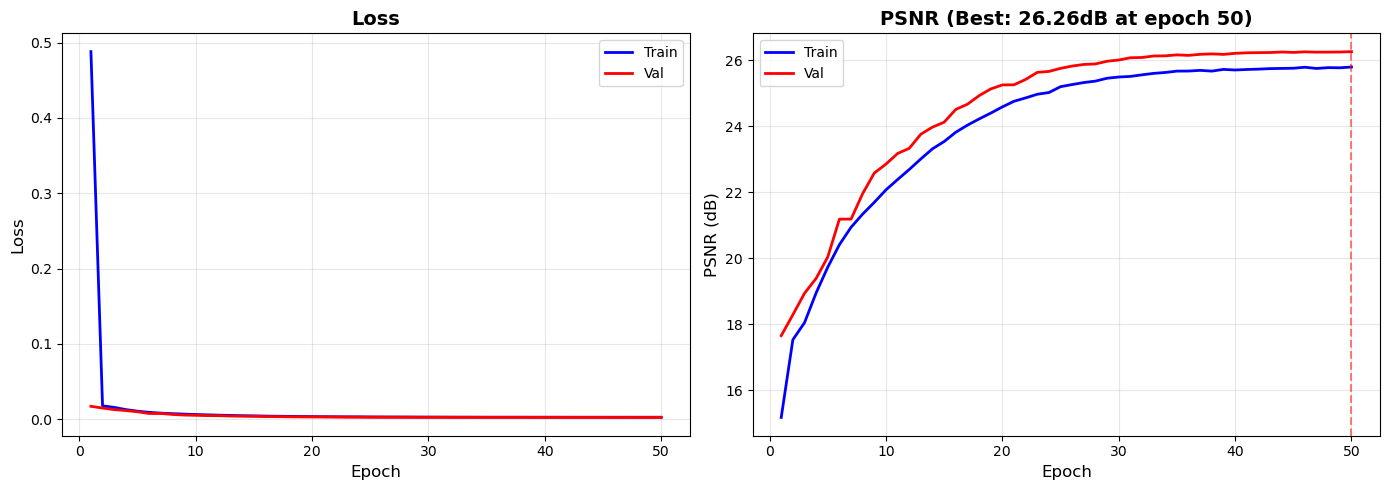


Denoising Results:


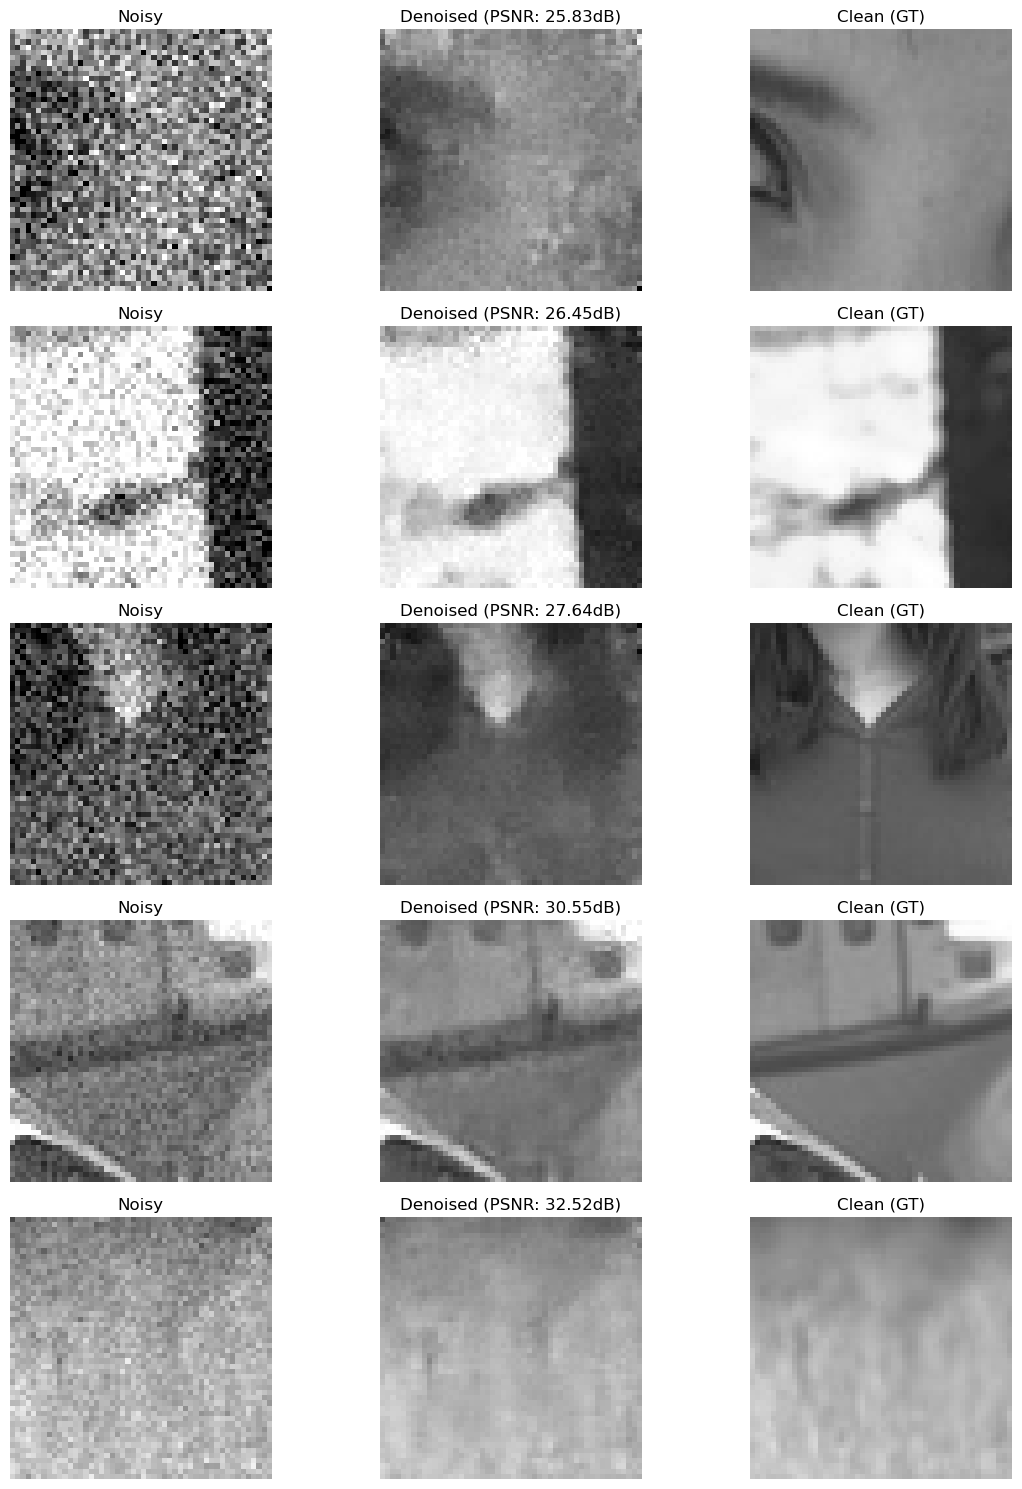

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 1. Loss & PSNR 그래프
# ============================================================================
def plot_results(history):
    """Loss와 PSNR 그래프 그리기"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # PSNR
    axes[1].plot(epochs, history['train_psnr'], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_psnr'], 'r-', label='Val', linewidth=2)
    best_epoch = np.argmax(history['val_psnr']) + 1
    best_psnr = max(history['val_psnr'])
    axes[1].axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('PSNR (dB)', fontsize=12)
    axes[1].set_title(f'PSNR (Best: {best_psnr:.2f}dB at epoch {best_epoch})', 
                     fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# 2. Denoising 결과 시각화
# ============================================================================
def show_denoising_results(model, dataloader, device, num_samples=5):
    """
    Noisy → Denoised 결과 이미지 비교
    """
    model.eval()
    
    # 샘플 가져오기
    noisy_list = []
    clean_list = []
    denoised_list = []
    
    with torch.no_grad():
        for noisy, clean in dataloader:
            noisy = noisy.to(device)
            clean = clean.to(device)
            
            # Denoising
            noise_pred = model(noisy)
            denoised = noisy - noise_pred
            
            noisy_list.append(noisy.cpu())
            clean_list.append(clean.cpu())
            denoised_list.append(denoised.cpu())
            
            if len(noisy_list) * noisy.size(0) >= num_samples:
                break
    
    # Tensor 합치기
    noisy_all = torch.cat(noisy_list, dim=0)[:num_samples]
    clean_all = torch.cat(clean_list, dim=0)[:num_samples]
    denoised_all = torch.cat(denoised_list, dim=0)[:num_samples]
    
    # 시각화
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*3))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Numpy 변환 [C, H, W] → [H, W] (grayscale)
        noisy_img = noisy_all[i].squeeze().numpy()
        clean_img = clean_all[i].squeeze().numpy()
        denoised_img = denoised_all[i].squeeze().numpy()
        
        # Clip
        noisy_img = np.clip(noisy_img, 0, 1)
        clean_img = np.clip(clean_img, 0, 1)
        denoised_img = np.clip(denoised_img, 0, 1)
        
        # PSNR 계산
        mse = np.mean((denoised_img - clean_img) ** 2)
        psnr = 10 * np.log10(1.0 / mse) if mse > 0 else float('inf')
        
        # Noisy
        axes[i, 0].imshow(noisy_img, cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title('Noisy', fontsize=12)
        axes[i, 0].axis('off')
        
        # Denoised
        axes[i, 1].imshow(denoised_img, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(f'Denoised (PSNR: {psnr:.2f}dB)', fontsize=12)
        axes[i, 1].axis('off')
        
        # Clean (Ground Truth)
        axes[i, 2].imshow(clean_img, cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title('Clean (GT)', fontsize=12)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# 실행
# ============================================================================

# 1. Loss & PSNR 그래프
plot_results(history)

# 2. Denoising 결과 (validation set에서 5개)
print('\nDenoising Results:')
show_denoising_results(model, val_loader, device, num_samples=5)

# 3. Test set 결과도 보고 싶다면
# show_denoising_results(model, test_loader, device, num_samples=5)